In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

import numpy as np
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
epochs = 20
batch_size = 32

## Loading data

In [3]:

train_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_train.csv'
test_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_valid.csv'
train_data = pd.read_csv(train_p,  sep=',')
test_data = pd.read_csv(test_p,  sep=',')
print(f'Train set shape: {train_data.shape}. Test set shape: {test_data.shape}')

Train set shape: (27455, 785). Test set shape: (7172, 785)


In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


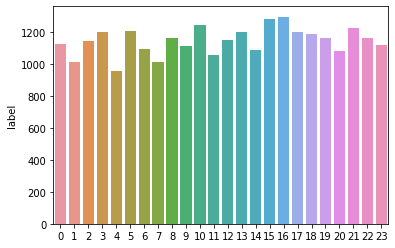

In [5]:
sns.barplot(x=train_data.label.value_counts().index, y=train_data.label.value_counts())
plt.show()

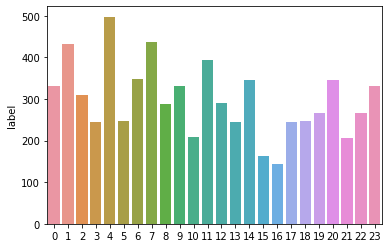

In [6]:
sns.barplot(x=test_data.label.value_counts().index, y=test_data.label.value_counts())
plt.show()

In [7]:
unq_classes = set(list(train_data['label'])+list(test_data['label']))
n_classes = len(unq_classes)
print('number of classes: ', n_classes)
print('classes: ', unq_classes)

number of classes:  24
classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


## Preparing data

In [8]:
y_train = train_data['label']
y_val = test_data['label']
del train_data['label']
del test_data['label']

X_train = train_data.values.reshape(-1,1,28,28)
X_val = test_data.values.reshape(-1,1,28,28)

print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
print(f'X_test shape: {X_val.shape}. y_test shape: {y_val.shape}')

X_train shape: (27455, 1, 28, 28). y_train shape: (27455,)
X_test shape: (7172, 1, 28, 28). y_test shape: (7172,)


### Showing some image and label examples

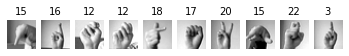

In [9]:
# Showing image examples
def show_imgs(feature_lists, labels):
    for i, (features, label) in enumerate(zip (feature_lists, labels)):
        image = features.reshape(28, 28)
        plt.subplot(1, len(labels), i+1)
        plt.title(label, fontdict={'fontsize': 10})
        plt.axis('off')
        plt.imshow(image, cmap='gray')

show_imgs(X_train[15:25], y_train[15:25])

### Normalize the data


In [10]:
# Exploring min and max values of image pixels
print(f'X_train: min= {X_train.min()}, max={X_train.max()}')

# Normalize images by dividing pixel values by the max
X_train = X_train/255
X_val = X_val/255
# X_test = X_test/255

y_train = y_train.values
y_val = y_val.values
# y_test = y_test.values

print('\nAfter normalizing:')
print(f'X_train: min= {X_train.min()}, max={X_train.max()}')
print(f'X_val: min= {X_val.min()}, max={X_val.max()}')
# print(f'X_test: min= {X_test.min()}, max={X_test.max()}')

X_train: min= 0, max=255

After normalizing:
X_train: min= 0.0, max=1.0
X_val: min= 0.0, max=1.0


### Loading data to Dataset and Dataloader object

In [11]:

class CustomDataset():
    def __init__(self, X, Y) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        # print(type(self.X), type(self.Y))


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        self.x_tensor = torch.tensor(x, dtype = torch.float) #float32
        self.y_tensor = torch.tensor(y, dtype = torch.long)
        return self.x_tensor, self.y_tensor

# passing data to the customized dataset class we created
train_datatensor = CustomDataset(X_train, y_train)
val_datatensor = CustomDataset(X_val, y_val)
# test_datatensor = CustomDataset(X_test, y_test)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )
# test_dataloader = DataLoader(test_datatensor, sampler = torch.utils.data.SequentialSampler(test_datatensor), batch_size=batch_size )



In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


## Creating model

In [13]:
class CNNNet(nn.Module):
    def __init__(self, n_classes) -> None:
        super(CNNNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=3, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=3, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(2*2*25, 512)
        self.fc2 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print('input x', x.size())
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        # print('after block 1', x.size())

        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        # print('after block 2', x.size())

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)
        # print('after block 3', x.size())
# 
        # x = torch.flatten(x, -1)
        x = x.view(-1,2*2*25 )
        # print('after flattening', x.size())

        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return self.softmax(x)


model= CNNNet(n_classes = n_classes)
print(model)

CNNNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


In [14]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

## Training model

In [15]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total = 0
    correct = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            # print('labels.size(0)', labels.size(0))
            total+= 1 #labels.size(0)
            correct+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct / total, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(train_dataloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(val_dataloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    checkpoint_p = './asl_cnn.pth'
    if val_loss < best_loss:
        torch.save(model, checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')




100%|██████████| 225/225 [00:05<00:00, 38.07it/s]


Epoch 1/20: Train loss = 3.0329642443112284, Validation loss = 2.9333913485209147, Validation accuracy: 0.3754


100%|██████████| 225/225 [00:07<00:00, 31.38it/s]


Epoch 2/20: Train loss = 2.6829746278015882, Validation loss = 2.6584107144673665, Validation accuracy: 0.6432


100%|██████████| 225/225 [00:06<00:00, 36.06it/s]


Epoch 3/20: Train loss = 2.4978637159009636, Validation loss = 2.565308821996053, Validation accuracy: 0.7175


100%|██████████| 225/225 [00:06<00:00, 32.41it/s]


Epoch 4/20: Train loss = 2.421218982943288, Validation loss = 2.4777115366193985, Validation accuracy: 0.8047


100%|██████████| 225/225 [00:06<00:00, 35.33it/s]


Epoch 5/20: Train loss = 2.3730106906735258, Validation loss = 2.438007928000556, Validation accuracy: 0.8494


100%|██████████| 225/225 [00:09<00:00, 24.59it/s]


Epoch 6/20: Train loss = 2.316371453391922, Validation loss = 2.392769185172187, Validation accuracy: 0.8906


100%|██████████| 225/225 [00:09<00:00, 24.28it/s]


Epoch 7/20: Train loss = 2.299890841915335, Validation loss = 2.3771962208218045, Validation accuracy: 0.8943


100%|██████████| 225/225 [00:09<00:00, 23.21it/s]


Epoch 8/20: Train loss = 2.294021929894294, Validation loss = 2.381423986223009, Validation accuracy: 0.8899


100%|██████████| 225/225 [00:10<00:00, 22.11it/s]


Epoch 9/20: Train loss = 2.291801735793516, Validation loss = 2.372732881969876, Validation accuracy: 0.8969


100%|██████████| 225/225 [00:07<00:00, 29.72it/s]


Epoch 10/20: Train loss = 2.2897503845619434, Validation loss = 2.3630934884813097, Validation accuracy: 0.9069


100%|██████████| 225/225 [00:08<00:00, 26.60it/s]


Epoch 11/20: Train loss = 2.2651853116797955, Validation loss = 2.3259975062476266, Validation accuracy: 0.9478


100%|██████████| 225/225 [00:08<00:00, 25.42it/s]


Epoch 12/20: Train loss = 2.2542636177756568, Validation loss = 2.3063097551133898, Validation accuracy: 0.9644


100%|██████████| 225/225 [00:13<00:00, 17.08it/s]


Epoch 13/20: Train loss = 2.252787985168137, Validation loss = 2.3137682512071396, Validation accuracy: 0.9569


100%|██████████| 225/225 [00:09<00:00, 24.90it/s]


Epoch 14/20: Train loss = 2.252738188196729, Validation loss = 2.314158233006795, Validation accuracy: 0.9590


100%|██████████| 225/225 [00:07<00:00, 31.35it/s]


Epoch 15/20: Train loss = 2.251459997017067, Validation loss = 2.300714223649767, Validation accuracy: 0.9710


100%|██████████| 225/225 [00:07<00:00, 31.82it/s]


Epoch 16/20: Train loss = 2.2510208461112353, Validation loss = 2.2989367230733238, Validation accuracy: 0.9672


100%|██████████| 225/225 [00:07<00:00, 31.90it/s]


Epoch 17/20: Train loss = 2.2504412272037606, Validation loss = 2.3031001991695828, Validation accuracy: 0.9635


100%|██████████| 225/225 [00:08<00:00, 25.05it/s]


Epoch 18/20: Train loss = 2.2504515420028937, Validation loss = 2.298786746131049, Validation accuracy: 0.9654


100%|██████████| 225/225 [00:11<00:00, 19.83it/s]


Epoch 19/20: Train loss = 2.250122017515845, Validation loss = 2.297799661424425, Validation accuracy: 0.9632


100%|██████████| 225/225 [00:12<00:00, 17.94it/s]

Epoch 20/20: Train loss = 2.2499814425315057, Validation loss = 2.3047560373942058, Validation accuracy: 0.9571


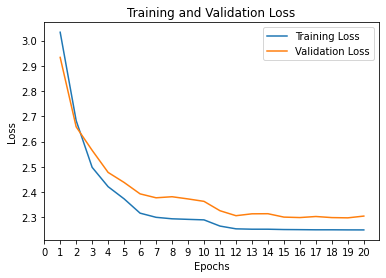

In [17]:
from numpy import arange

# Visualize the loss 
epochs = range(1, 21)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, validation_loss_values, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 1))
 
plt.legend(loc='best')
plt.show()

In [18]:
validation_loss_values

[2.9333913485209147,
 2.6584107144673665,
 2.565308821996053,
 2.4777115366193985,
 2.438007928000556,
 2.392769185172187,
 2.3771962208218045,
 2.381423986223009,
 2.372732881969876,
 2.3630934884813097,
 2.3259975062476266,
 2.3063097551133898,
 2.3137682512071396,
 2.314158233006795,
 2.300714223649767,
 2.2989367230733238,
 2.3031001991695828,
 2.298786746131049,
 2.297799661424425,
 2.3047560373942058]

## Testing model

In [16]:
# model.load_state_dict(best_model_wts)
# _, test_accuracy, test_preds = eval_fn(test_dataloader, model)
# print(f'Model performance on test set: Accuracy = {test_accuracy}')